# Pipeline for High-z Radio Galaxies 05: Redshift prediction (high z, new instance with data balancing)

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done only with AGN from the Million Quasar Catalog (MQC).  
Only sources with confirmed $z$ will be used.

Also, as a test, only high-redshift sources ($z \geq 3.6$ (or $3.7$), from recall behaviour. Turn-off point) will be used.  
Additionally, SMOGN will be used to increase the parameter space size oversampling highest redshift elements.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import regression as pyr
import pandas as pd
import smogn
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

***

## Reading data

We import our data using the `pandas` package.

In [3]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True
run_smoter_flag = False
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [4]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 'TYPE',\
                      'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP',\
                      'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed',\
                      'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [5]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [6]:
full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'LOFAR_detect'].astype(int)

In [7]:
target_feat = 'Z'

Combine redshift values (AGN + galaxies).

In [8]:
idx_non_Z                = full_catalog_df.loc[:, target_feat].where(full_catalog_df.loc[:, target_feat] > 0).isna()
full_catalog_df.loc[idx_non_Z, target_feat] = full_catalog_df.loc[:, target_feat].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [9]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'LOFAR_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
print('Shape of used data in HETDEX')
print('-' * 65)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 65)
print()

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (83409, 88)
Data for Modeling (Train, Test, and Calibration): (66727, 88)
Training data:                                    (53381, 88)
Testing data:                                     (6673, 88)
Calibration data:                                 (6673, 88)
Validation data:                                  (16682, 88)
-----------------------------------------------------------------



In [10]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'LOFAR_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'LOFAR_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'LOFAR_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'LOFAR_detect'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'is_AGN'] == 1) & (calibration_df.loc[:, 'LOFAR_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'LOFAR_detect'] == 1)]

#### Select high-z objects

In [11]:
filter_high_z    = full_catalog_df.loc[:, target_feat] >= gv.high_z_limit
full_catalog_df  = full_catalog_df.loc[full_catalog_df.loc[:, target_feat] >= gv.high_z_limit]
train_test_df    = train_test_df.loc[train_test_df.loc[:, target_feat] >= gv.high_z_limit]
train_df         = train_df.loc[train_df.loc[:, target_feat] >= gv.high_z_limit]
test_df          = test_df.loc[test_df.loc[:, target_feat] >= gv.high_z_limit]
calibration_df   = calibration_df.loc[calibration_df.loc[:, target_feat] >= gv.high_z_limit]
validation_df    = validation_df.loc[validation_df.loc[:, target_feat] >= gv.high_z_limit]

In [12]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 1,891 elements,
1,891 of them are marked as AGN, and, from them, 1,891 have confirmed radio detection.


#### Remove intermediate targets

In [13]:
cols_to_remove_cl = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'LOFAR_detect', 'zsp']
full_catalog_df = full_catalog_df.drop(columns=cols_to_remove_cl)
train_test_df   = train_test_df.drop(columns=cols_to_remove_cl)
train_df        = train_df.drop(columns=cols_to_remove_cl)
test_df         = test_df.drop(columns=cols_to_remove_cl)
calibration_df  = calibration_df.drop(columns=cols_to_remove_cl)
validation_df   = validation_df.drop(columns=cols_to_remove_cl)

---

In [14]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (1891, 80)
Data for Modeling (Train and Test): (1503, 80)
Training data:                      (1175, 80)
Testing data:                       (170, 80)
Calibration data:                   (158, 80)
Validation data:                    (388, 80)
--------------------------------------------------


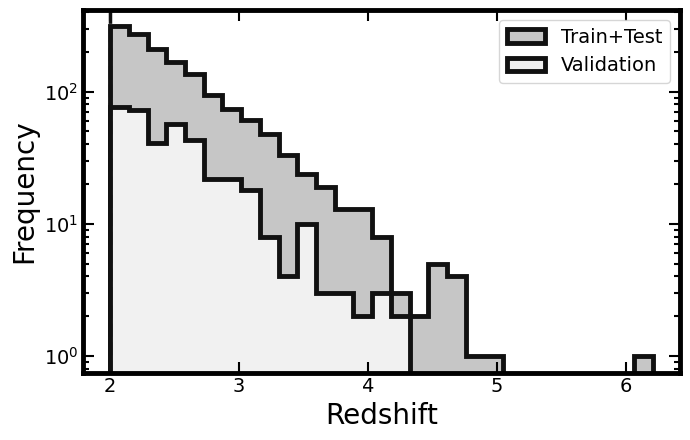

In [15]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [16]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use SMOGN for data augmentation at high redshifts

In [17]:
if run_smoter_flag:
    backup_train_df = train_df.copy()

In [18]:
if run_smoter_flag:
    train_df = smogn.smoter(
        
        ## main arguments
        data          = backup_train_df.reset_index(drop=True),  ## pandas dataframe
        y             = target_feat,                             ## string ('header name')
        k             = 10,                                      ## positive integer (k < n), 4
        samp_method   = 'extreme',                               ## string ('balance' or 'extreme')
        drop_na_col   = False,
        drop_na_row   = False,
        under_samp    = True,
        seed          = gv.seed,
        replace       = False,
    
        ## phi relevance arguments
        rel_thres     = 0.85,                                    ## positive real number (0 < R < 1), 0.5
        rel_method    = 'auto',                                  ## string ('auto' or 'manual')
        rel_xtrm_type = 'both',                                  ## string ('low' or 'both' or 'high')
        rel_coef      = 2.00                                     ## positive real number (0 < R), 2.85
    )

In [19]:
if run_smoter_flag:
    print('Shape of new used data (after SMOGN)')
    print('-' * 40)
    print(f'Data for Modeling (Train and Test): {train_df.shape}')
    print('-' * 40)

In [20]:
if run_smoter_flag:
    fig             = plt.figure(figsize=(7,4.5))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='log')
    
    min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
    max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
    score_bins = np.linspace(min_score, max_score, 40)
    
    ax1.hist(train_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
             lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='SMOGN Train')
    ax1.hist(backup_train_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
             lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.75, label='Original Train')
    
    ax1.axvline(x=redshift_low_lim, ls='--', c='k', lw=2.5)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    # ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()

---

## Use Correlation matrix to discard some features

In [21]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [22]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [23]:
rsd_vals

K_W3        613.547420
z_y         371.175904
r_i         177.415317
i_z         146.221847
g_r         136.843051
i_y         136.158555
g_i         121.147048
y_W1        110.969910
r_z         107.595446
r_y         104.978492
g_z          89.195254
g_y          88.440907
z_W1         85.030304
y_W2         73.597522
W1_W2        71.552600
i_W1         69.728578
r_W1         65.471384
g_W1         65.247597
z_W2         59.974403
i_W2         53.831564
g_W2         51.380927
r_W2         51.316939
H_W3         45.639853
y_J          44.797565
y_H          41.212351
z_J          40.686465
i_J          38.858908
z_H          37.579317
r_J          36.697153
i_H          36.100765
g_J          35.639966
J_W3         34.922256
r_H          34.230442
g_H          33.450661
y_K          33.113730
z_K          30.480619
i_K          29.656921
y_W3         28.473827
r_K          28.368162
g_K          28.107940
z_W3         25.887505
i_W3         25.427431
g_W3         25.097762
W2_W3      

In [24]:
correlation = norm_train_test_df.corr()

In [25]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [26]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [27]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [28]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [29]:
list_drop_corr

['g_H',
 'y_H',
 'i_H',
 'r_H',
 'z_H',
 'gmag',
 'ymag',
 'imag',
 'rmag',
 'zmag',
 'J_W2',
 'J_W1',
 'K_W2',
 'K_W1',
 'g_K',
 'y_K',
 'i_K',
 'r_K',
 'z_K',
 'J_W3',
 'g_W4',
 'W3mag',
 'y_W4',
 'i_W4',
 'r_W4',
 'z_W4',
 'W2mproPM',
 'W1mproPM',
 'H_W2',
 'H_W1',
 'H_W3',
 'W3_W4',
 'Jmag',
 'Hmag',
 'H_W4',
 'r_J',
 'g_W2',
 'i_J',
 'g_W3',
 'W1_W4',
 'r_W3',
 'y_W3',
 'i_W3',
 'z_W3',
 'J_K',
 'r_W2',
 'W2_W4',
 'y_W2',
 'i_W2',
 'W1_W3',
 'W4mag',
 'z_J',
 'z_W2',
 'r_W1',
 'g_i',
 'i_W1',
 'r_y',
 'g_J',
 'Kmag',
 'g_y',
 'W2_W3',
 'g_z',
 'i_y']

In [30]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [31]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [32]:
corr_discard = norm_train_test_discard.corr()

In [33]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z       1.000000
y_W1      z_W1    0.741658
z_W1      g_W1    0.731580
y_J       y_W1    0.701786
band_num  y_J     0.694666
r_z       i_z     0.683218
g_W1      g_r     0.662374
r_i       r_z     0.660561
J_W4      K_W4    0.657673
H_K       J_W4    0.614013
g_W1      y_W1    0.610524
K_W4      K_W3    0.560720
K_W3      y_J     0.524851
W1_W2     Z       0.522987
y_J       z_W1    0.519680
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

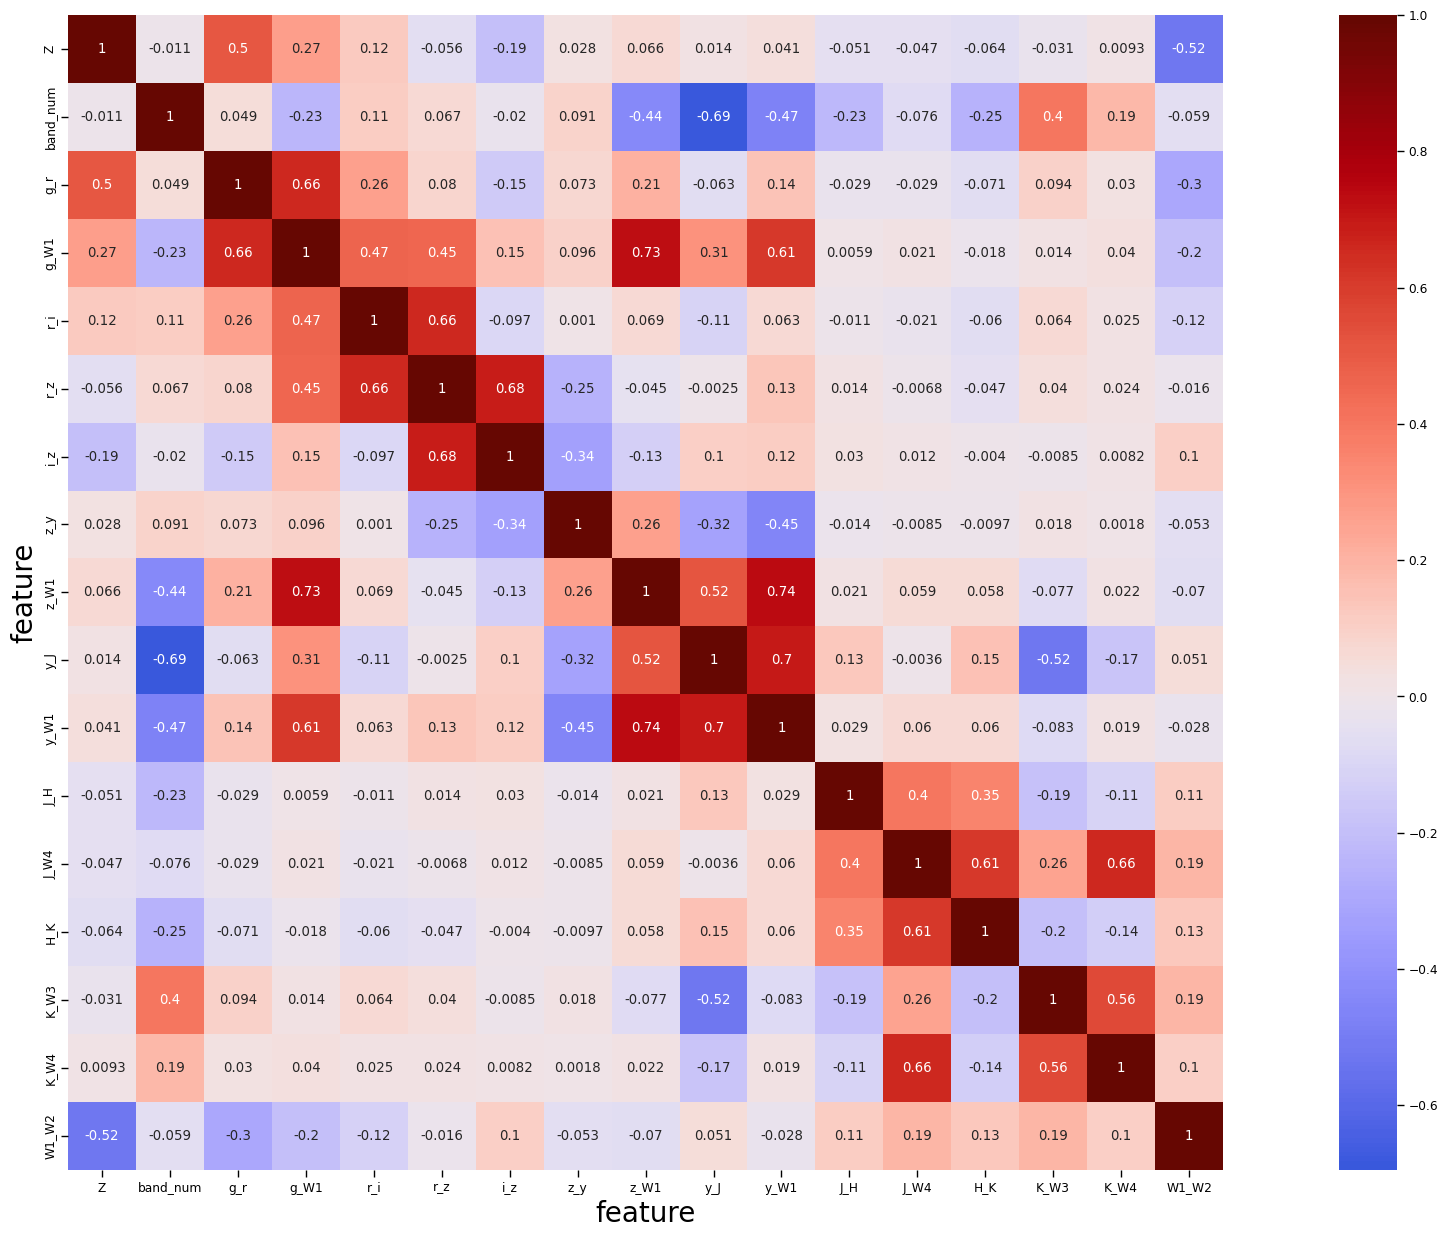

In [34]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [35]:
# norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [36]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [37]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
H_K       H_K         1.000000
band_num  y_J         0.450071
J_W4      K_W4        0.374800
band_num  y_W1        0.351022
y_W1      z_W1        0.253188
band_num  z_y         0.248785
z_W1      y_W1        0.228175
y_J       band_num    0.218679
z_W1      g_W1        0.214056
y_W1      y_J         0.212256
z_y       y_J         0.202135
y_J       y_W1        0.191760
K_W4      J_W4        0.185589
K_W3      K_W4        0.184153
g_W1      z_W1        0.177962
band_num  z_W1        0.129575
K_W3      y_J         0.116048
y_W1      g_W1        0.115257
z_y       y_W1        0.087503
r_z       i_z         0.069386
dtype: float64

In [38]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [39]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [40]:
list_drop_pps = []

In [41]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [42]:
list_drop_pps

[]

In [43]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [44]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [45]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0,regression,True,mean absolute error,0.08602,0.090377,DecisionTreeRegressor()
1,g_r,Z,0,regression,True,mean absolute error,0.08602,0.103104,DecisionTreeRegressor()
2,g_W1,Z,0,regression,True,mean absolute error,0.08602,0.121516,DecisionTreeRegressor()
3,r_i,Z,0,regression,True,mean absolute error,0.08602,0.118249,DecisionTreeRegressor()
4,r_z,Z,0,regression,True,mean absolute error,0.08602,0.113793,DecisionTreeRegressor()
5,i_z,Z,0,regression,True,mean absolute error,0.08602,0.106148,DecisionTreeRegressor()
6,z_y,Z,0,regression,True,mean absolute error,0.08602,0.120561,DecisionTreeRegressor()
7,z_W1,Z,0,regression,True,mean absolute error,0.08602,0.120118,DecisionTreeRegressor()
8,y_J,Z,0,regression,True,mean absolute error,0.08602,0.112964,DecisionTreeRegressor()
9,y_W1,Z,0,regression,True,mean absolute error,0.08602,0.120952,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [46]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('band_num')  # After Boruta
final_feats.remove('y_J')       # After Boruta
final_feats.remove('J_H')       # After Boruta
final_feats.remove('J_W4')      # After Boruta
final_feats.remove('H_K')       # After Boruta
final_feats.remove('K_W3')      # After Boruta
final_feats.remove('K_W4')      # After Boruta

In [47]:
# feats_2_discard = list_drop_corr + list_drop_pps
feats_2_discard = list_drop_corr + list_drop_pps + ['band_num', 'y_J', 'J_H', 'J_W4', 'H_K', 'K_W3', 'K_W4']

Boruta discards one feature.

In [48]:
exp_radio = pyr.setup(data=train_df, test_data=test_df, target=target_feat, session_id=gv.seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta',\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(1175, 80)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1175, 9)"


In [49]:
pyr.get_config('X').columns

Index(['g_r', 'g_W1', 'r_i', 'r_z', 'i_z', 'z_y', 'z_W1', 'y_W1', 'W1_W2'], dtype='object')

In [50]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [51]:
pyr.add_metric('s_mad',  'sigma_mad',    gf.sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   gf.sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      gf.sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', gf.sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   gf.outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7fe025ae7820>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [52]:
metric_2_opt          = 's_mad'
final_selection_reg   = ['rf', 'catboost', 'gbr', 'et', 'xgboost', 'dummy']
initial_selection_reg = ['rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, small sample => too slow)
n_models              = 5
top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort=metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z          = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
et,Extra Trees Regressor,0.2236,0.1135,0.3315,0.5580,0.0869,0.0868,0.2324,0.0675,0.3315,0.0890,0.0740,0.0380
catboost,CatBoost Regressor,0.2233,0.1080,0.3239,0.5854,0.0856,0.0862,0.2342,0.0677,0.3239,0.0857,0.0672,0.4670
xgboost,Extreme Gradient Boosting,0.2359,0.1200,0.3414,0.5353,0.0900,0.0911,0.2346,0.0676,0.3414,0.0908,0.0834,7.8760
gbr,Gradient Boosting Regressor,0.2286,0.1175,0.3360,0.5440,0.0874,0.0879,0.2422,0.0694,0.3360,0.0891,0.0723,0.0350
rf,Random Forest Regressor,0.2251,0.1161,0.3349,0.5444,0.0877,0.0873,0.2426,0.0689,0.3349,0.0899,0.0655,0.4090
dummy,Dummy Regressor,0.3855,0.2653,0.5121,-0.0075,0.1324,0.1454,0.5005,0.1467,0.5121,0.1258,0.2418,0.0050


Thus, we select `et` as meta learner (based upon $\sigma_{\mathrm{MAD}}$).

Thus, we stack the models.

In [53]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0],\
                                   optimize=metric_2_opt, restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2482,0.1191,0.3452,0.3447,0.0943,0.1010,0.2680,0.0806,0.3452,0.0992,0.1017
1,0.2119,0.0970,0.3114,0.6459,0.0839,0.0824,0.2179,0.0614,0.3114,0.0888,0.0593
2,0.2116,0.0837,0.2893,0.6743,0.0803,0.0856,0.2268,0.0649,0.2893,0.0846,0.0678
3,0.2473,0.1026,0.3203,0.4330,0.0894,0.0966,0.3220,0.0870,0.3203,0.0886,0.0763
4,0.2039,0.0895,0.2992,0.6556,0.0825,0.0820,0.1708,0.0508,0.2992,0.0868,0.0763
5,0.2240,0.0939,0.3065,0.6926,0.0808,0.0842,0.2547,0.0670,0.3065,0.0790,0.0684
6,0.2494,0.1427,0.3777,0.3940,0.1001,0.0971,0.2319,0.0705,0.3777,0.1069,0.1026
7,0.2528,0.2205,0.4696,0.4410,0.1075,0.0894,0.2723,0.0713,0.4696,0.0929,0.0855
8,0.2141,0.1062,0.3259,0.6276,0.0830,0.0801,0.1798,0.0521,0.3259,0.0825,0.0684


In [54]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping=True, optimize=metric_2_opt,\
                               search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2391,0.1142,0.3379,0.3718,0.0923,0.0977,0.2672,0.0800,0.3379,0.0975,0.0932
1,0.2068,0.0888,0.2981,0.6756,0.0802,0.0797,0.1925,0.0555,0.2981,0.0837,0.0339
2,0.2114,0.0782,0.2796,0.6958,0.0776,0.0849,0.2370,0.0638,0.2796,0.0808,0.0678
3,0.2414,0.0969,0.3112,0.4648,0.0864,0.0938,0.2865,0.0824,0.3112,0.0857,0.0678
4,0.1943,0.0818,0.2861,0.6852,0.0786,0.0778,0.1788,0.0562,0.2861,0.0829,0.0763
5,0.2194,0.0874,0.2957,0.7138,0.0778,0.0821,0.2451,0.0696,0.2957,0.0764,0.0684
6,0.2431,0.1373,0.3705,0.4168,0.0978,0.0956,0.2298,0.0702,0.3705,0.1060,0.0769
7,0.2418,0.2108,0.4592,0.4654,0.1047,0.0858,0.2517,0.0683,0.4592,0.0904,0.0684
8,0.2169,0.1123,0.3351,0.6062,0.0845,0.0802,0.2004,0.0562,0.3351,0.0816,0.0513


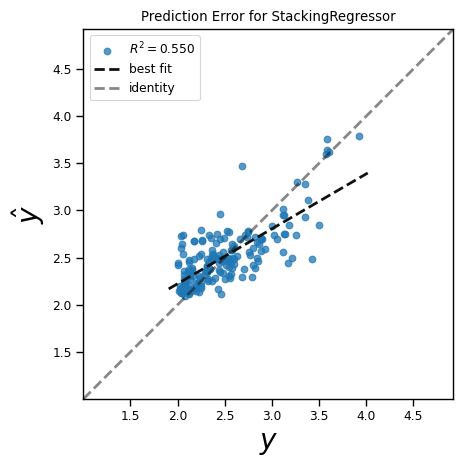

In [55]:
pyr.plot_model(tuned_z_reg, plot='error')

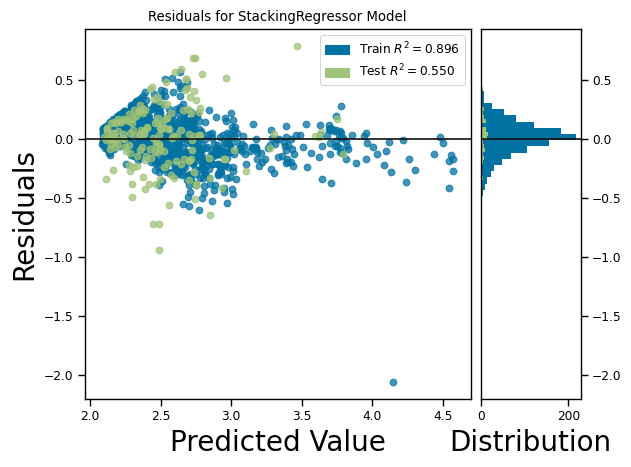

In [56]:
pyr.plot_model(tuned_z_reg, plot='residuals')

In [ ]:
# pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [57]:
pyr.plot_model(tuned_z_reg.final_estimator_, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mse
max_depth,8
max_features,0.9631316254094502
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,1.0157210681093717e-09
min_impurity_split,None
min_samples_leaf,4


In [58]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mse
max_depth,8
max_features,0.9631316254094502
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,1.0157210681093717e-09
min_impurity_split,None
min_samples_leaf,4


In [59]:
plt.rcParams.update(plt.rcParamsDefault)

In [60]:
pyr.predict_model(tuned_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2041,0.0750,0.2739,0.5504,0.0763,0.0819,0.2400,0.0669,0.2739,0.0774,0.0706


,Z,Label
count,170.000000,170.000000
mean,2.501088,2.514636
std,0.409682,0.320884
min,2.002000,2.096870
25%,2.171750,2.298746
50%,2.411000,2.467835
75%,2.731500,2.679613
max,3.920000,3.789828


In [61]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2041,0.0750,0.2739,0.5504,0.0763,0.0819,0.2400,0.0669,0.2739,0.0774,0.0706


In [62]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [63]:
pyr.predict_model(final_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2041,0.0750,0.2739,0.5504,0.0763,0.0819,0.2400,0.0669,0.2739,0.0774,0.0706


,Z,Label
count,170.000000,170.000000
mean,2.501088,2.514636
std,0.409682,0.320884
min,2.002000,2.096870
25%,2.171750,2.298746
50%,2.411000,2.467835
75%,2.731500,2.679613
max,3.920000,3.789828


In [65]:
if save_model_flag:
    pyr.save_model(final_z_reg, gv.models_path + gv.high_z_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [50]:
if load_model_flag:
    final_z_reg = pyr.load_model(gv.models_path + gv.high_z_model)  # for z >= 4, regression_z_may_31_4_2022

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [66]:
base_models_names = gf.get_base_estimators_names(final_z_reg)
base_models       = gf.get_base_estimators_models(final_z_reg)

In [67]:
print('Running data pre-processing:\n')
extended_data_z_df = gf.preprocess_data(final_z_reg, validation_df, base_models_names)

Running data pre-processing:



In [68]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_z_reg, extended_data_z_df)

In [69]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_z_df)

In [70]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [71]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for catboost...
Calculating for xgboost...
Calculating for gbr...
Calculating for rf...


catboost            xgboost                gbr                 rf           
   Feature Importance Feature Importance Feature Importance Feature Importance
0      g_r  26.641506   W1_W2  32.953930     g_r  35.048013     g_r  31.193964
1    W1_W2  23.395694     g_r  19.409229   W1_W2  28.418021   W1_W2  25.055891
2      i_z   9.760998     i_z  10.193643     i_z   9.471280     i_z   9.012866
3      z_y   9.481468     r_z   8.547462     r_z   6.856286     z_y   8.030604
4      r_z   8.807002    g_W1   7.119089     z_y   6.782618     r_z   7.243429
5     g_W1   5.975004    z_W1   6.699553    g_W1   4.900490     r_i   5.954728
6      r_i   5.776794     r_i   5.687845    z_W1   3.796408    g_W1   5.419368
7     z_W1   5.758766     z_y   5.553289     r_i   2.780476    z_W1   4.723036
8     y_W1   4.402769    y_W1   3.835960    y_W1   1.946409    y_W1   3.366113

In [72]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,catboost,30.054819
1,rf,27.904145
2,xgboost,20.774279
3,gbr,8.742016
4,g_r,2.264729
5,g_W1,1.732253
6,W1_W2,1.465946
7,z_W1,1.390398
8,i_z,1.223152
9,z_y,1.147615


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
g_r	26.697
W1_W2	23.553
i_z	9.755
z_y	9.403
r_z	8.770
g_W1	5.970
r_i	5.749
z_W1	5.739
y_W1	4.363


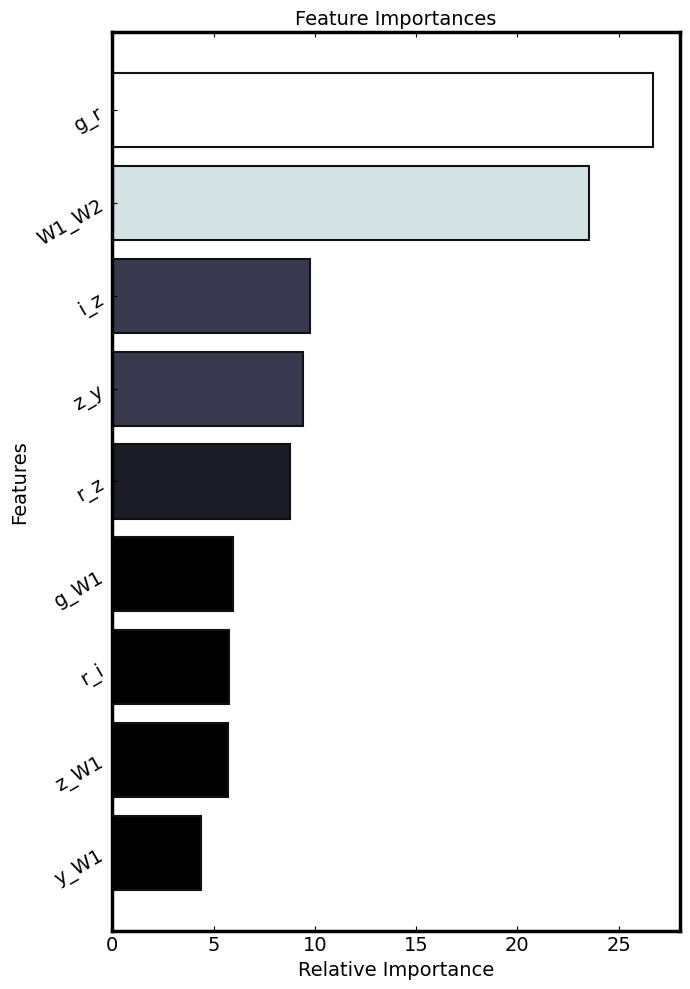

In [73]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = gf.get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        if redshift_low_lim == 3.7:
            plt.savefig(gv.plots_path + 'feat_imp_regression_z_08.pdf', bbox_inches='tight')
        elif redshift_low_lim == 3.6:
            plt.savefig(gv.plots_path + 'feat_imp_regression_z_09.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [74]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_z_reg, 'rf', 'regression')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,rf,catboost,xgboost,gbr,rf
n_estimators,51,NaN,100.0000,100.0000,100.0000
max_depth,8,NaN,6.0000,3.0000,NaN
min_impurity_decrease,0.0000,NaN,NaN,0.0000,0.0000
max_features,0.9631,NaN,NaN,None,auto
bootstrap,True,NaN,NaN,NaN,True
criterion,mse,NaN,NaN,NaN,mse
min_samples_split,2,NaN,NaN,2.0000,2.0000
min_samples_leaf,4,NaN,NaN,1.0000,1.0000
learning_rate,NaN,0.0420,0.3000,0.1000,NaN
depth,NaN,6.0000,NaN,NaN,NaN


---

In [75]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 1,175
Size of test set is  170


In [76]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
calib_prediction_reg      = pyr.predict_model(final_z_reg, data=calibration_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2205,0.0912,0.3021,0.5486,0.0817,0.0878,0.2608,0.0730,0.3021,0.0847,0.0670


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1175,0.0276,0.1661,0.8958,0.0440,0.0460,0.1269,0.0371,0.1661,0.0440,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2041,0.0750,0.2739,0.5504,0.0763,0.0819,0.2400,0.0669,0.2739,0.0774,0.0706


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2144,0.1031,0.3211,0.6055,0.0848,0.0829,0.2222,0.0633,0.3211,0.0911,0.0506


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1375,0.0409,0.2023,0.8388,0.0541,0.0540,0.1448,0.0416,0.2023,0.0553,0.0166


In [77]:
validation_prediction_reg.loc[:, [target_feat, 'Label']].describe()

,Z,Label
count,388.000000,388.000000
mean,2.529585,2.567274
std,0.450194,0.368267
min,2.000000,2.088721
25%,2.193000,2.307852
50%,2.444000,2.488675
75%,2.716250,2.709077
max,4.247000,4.185686


In [78]:
sigma_mad_train         = gf.sigma_mad(train_prediction_reg.loc[:, target_feat],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = gf.sigma_mad(test_prediction_reg.loc[:, target_feat],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = gf.sigma_mad(train_test_prediction_reg.loc[:, target_feat],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_calib         = gf.sigma_mad(calib_prediction_reg.loc[:, target_feat],         calib_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = gf.sigma_mad(validation_prediction_reg.loc[:, target_feat],    validation_prediction_reg.loc[:, 'Label'])

In [79]:
sigma_nmad_train        = gf.sigma_nmad(train_prediction_reg.loc[:, target_feat],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = gf.sigma_nmad(test_prediction_reg.loc[:, target_feat],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = gf.sigma_nmad(train_test_prediction_reg.loc[:, target_feat],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_calib        = gf.sigma_nmad(calib_prediction_reg.loc[:, target_feat],        calib_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = gf.sigma_nmad(validation_prediction_reg.loc[:, target_feat],   validation_prediction_reg.loc[:, 'Label'])

In [80]:
sigma_z_train           = gf.sigma_z(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = gf.sigma_z(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = gf.sigma_z(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_calib           = gf.sigma_z(calib_prediction_reg.loc[:, target_feat],           calib_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = gf.sigma_z(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

In [81]:
sigma_z_norm_train      = gf.sigma_z_norm(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = gf.sigma_z_norm(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = gf.sigma_z_norm(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_calib      = gf.sigma_z_norm(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = gf.sigma_z_norm(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

In [82]:
out_frac_train      = gf.outlier_frac(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
out_frac_test       = gf.outlier_frac(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
out_frac_train_test = gf.outlier_frac(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
out_frac_calib      = gf.outlier_frac(calib_prediction_reg.loc[:, target_feat],           calib_prediction_reg.loc[:, 'Label'])
out_frac_valid      = gf.outlier_frac(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

Display metrics as DataFrame

In [83]:
metrics_z = np.array([[sigma_mad_train,      sigma_nmad_train,      sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [sigma_mad_test,       sigma_nmad_test,       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [sigma_mad_train_test, sigma_nmad_train_test, sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [sigma_mad_calib,      sigma_nmad_calib,      sigma_z_calib,      sigma_z_norm_calib,      out_frac_calib],\
                      [sigma_mad_valid,      sigma_nmad_valid,      sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [84]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [85]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

,σ MAD,σ NMAD,σ z,σ z N,η
Train,0.1269,0.0371,0.1661,0.0440,0.0043
Test,0.2400,0.0669,0.2739,0.0774,0.0706
Train+Test,0.1448,0.0416,0.2023,0.0553,0.0166
Calibration,0.2222,0.0633,0.3211,0.0911,0.0506
Validation,0.2608,0.0730,0.3021,0.0847,0.0670


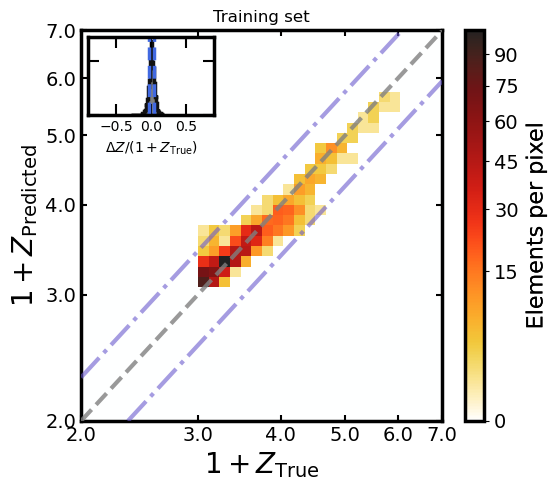

In [86]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(train_prediction_reg.loc[:, target_feat], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)

min_z = np.floor(train_prediction_reg.loc[:, [target_feat, 'Label']].min().min())
max_z = np.ceil(train_prediction_reg.loc[:, [target_feat, 'Label']].max().max())

ax1.set_xlim(left=min_z,   right=max_z)
ax1.set_ylim(bottom=min_z, top=max_z)

if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_redshift_09.pdf', bbox_inches='tight')
plt.show()

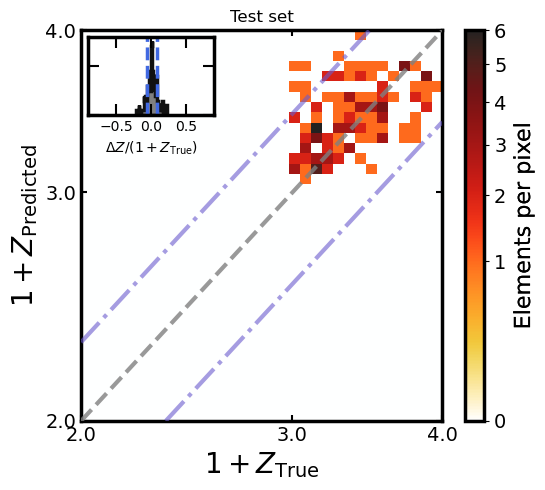

In [87]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(test_prediction_reg.loc[:, target_feat], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)

min_z = np.floor(test_prediction_reg.loc[:, [target_feat, 'Label']].min().min())
max_z = np.ceil(test_prediction_reg.loc[:, [target_feat, 'Label']].max().max())

ax1.set_xlim(left=min_z,   right=max_z)
ax1.set_ylim(bottom=min_z, top=max_z)

if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_test_redshift_09.pdf', bbox_inches='tight')
plt.show()

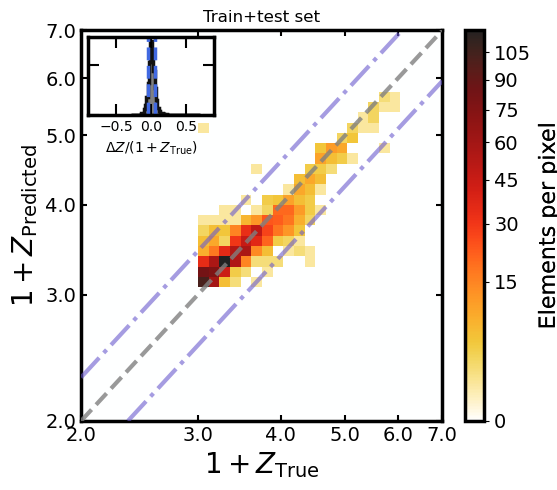

In [88]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Train+test set', dpi=10, show_clb=True, log_stretch=False)
min_z = np.floor(train_test_prediction_reg.loc[:, [target_feat, 'Label']].min().min())
max_z = np.ceil(train_test_prediction_reg.loc[:, [target_feat, 'Label']].max().max())

ax1.set_xlim(left=min_z,   right=max_z)
ax1.set_ylim(bottom=min_z, top=max_z)

if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_test_redshift_09.pdf', bbox_inches='tight')
plt.show()

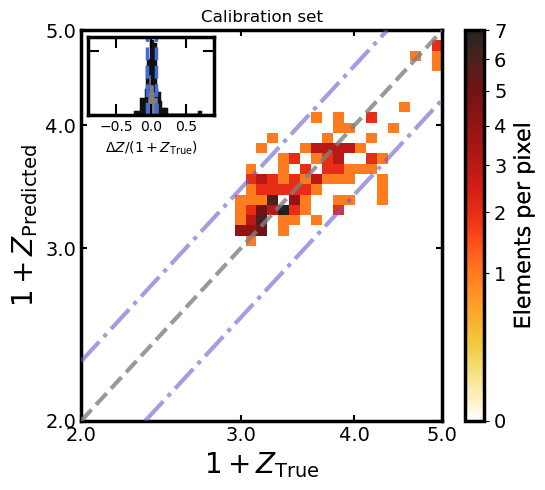

In [89]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(calib_prediction_reg.loc[:, target_feat], calib_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Calibration set', dpi=10, show_clb=True, log_stretch=False)

min_z = np.floor(calib_prediction_reg.loc[:, [target_feat, 'Label']].min().min())
max_z = np.ceil(calib_prediction_reg.loc[:, [target_feat, 'Label']].max().max())

ax1.set_xlim(left=min_z,   right=max_z)
ax1.set_ylim(bottom=min_z, top=max_z)

if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_calibration_redshift_09.pdf', bbox_inches='tight')
plt.show()

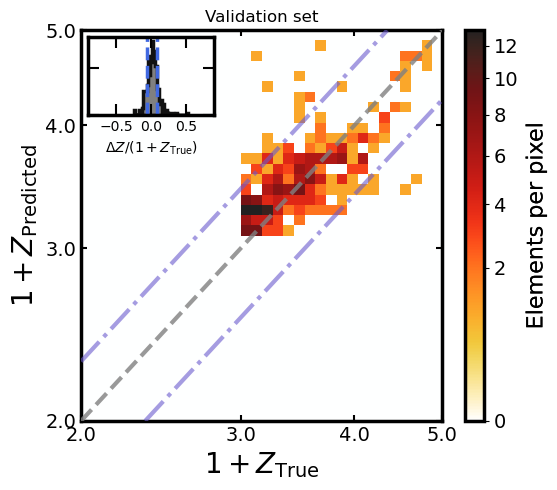

In [90]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
min_z = np.floor(validation_prediction_reg.loc[:, [target_feat, 'Label']].min().min())
max_z = np.ceil(validation_prediction_reg.loc[:, [target_feat, 'Label']].max().max())

ax1.set_xlim(left=min_z,   right=max_z)
ax1.set_ylim(bottom=min_z, top=max_z)

if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_validation_redshift_09.pdf', bbox_inches='tight')
plt.show()

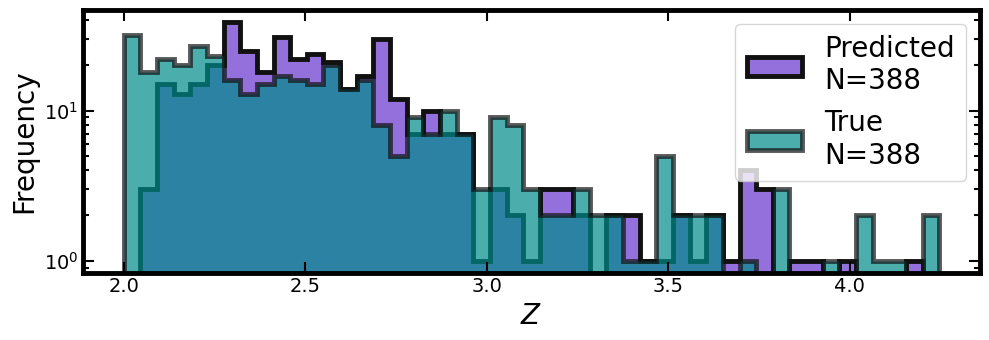

In [91]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, target_feat], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, target_feat] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_true_predicted_z_09.pdf')
plt.show()